### About Company:
--------------------------------------------------------------------------------------------------------------
BC Finance company deals in all home loans. They have a presence across all urban, semi-urban and rural areas. 
The customer first applies for a home loan after that company validates the customer's eligibility for a loan.

### Problem:
--------------------------------------------------------------------------------------------------------------
The company wants to automate the loan eligibility process (real-time) based on customer detail provided while 
filling out the online application form. 

The details the users need to provide include

| Detail            | Description                                             |
|--------------------|---------------------------------------------------------|
| Gender             | Gender of the applicant (Male/Female)                    |
| Married            | Applicant's marital status (Yes/No)                       |
| Dependents         | Number of dependents                                      |
| Education          | Applicant's education level (Graduate/Not Graduate)       |
| Self_Employed      | Whether the applicant is self-employed (Yes/No)           |
| ApplicantIncome    | Applicant's monthly income                                |
| CoapplicantIncome  | Co-applicant's monthly income                             |
| LoanAmount         | Loan amount requested (in thousands)                      |
| Loan_Amount_Term   | Term of loan Days                                |
| Credit_History     | Credit history meets guidelines (1 - Yes, 0 - No)         |
| Property_Area      | Location of property (Urban/Rural)              |


Based on a given dataset a machine learning model needs to be trained to predict whether a load will be approved or not (Folder location "./Machine-Learning-382-Project-1/Data)



Werner Janse van Rensburg (577930)

Jo-Anne van der Wath (577394)

Joshua Moll (578045)

Omphile Tladi (577776)

Chaleigh Storm (577716)

Nontsikelelo Sharon Buhlungu (577878)

--------------------------
----------------------

# MileStone 1: business Understanding


# Step 1 Problem statement
BC Finance offers home loans to consumers and determines eligibility manually. Loan approval decisions are influenced by a variety of personal details, including income, credit history, employment status, and other factors.  Understanding the correlations between these details and loan approval outcomes is crucial for developing a predictive model to automatically forecast loan approval eligibility.


--------------------------
----------------------
# Step 2 Hypothesis
The personal details of loan applicants exhibit correlations with loan approval outcomes. Analyzing these correlations using historical loan data will allow us to develop a predictive model that accurately forecasts loan approval based on applicant characteristics and historical patterns.
 
A few possible hypothesis to consider include the following:
1.	Applicants with higher income may be more likely to be eligible for loans
2.	Applicants who are not self-employed may be more likely to be approved for loans
3.	Applicants applying for smaller amounts may be more likely to be approved for loans
4.	Applicants with good credit history will be more likely to be approved 

--------------------------
----------------------
# Step 3 Getting the system ready




In [33]:

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from category_encoders import OneHotEncoder
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import dash
from dash import html, dcc, Input, Output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from skimpy import skim


### <u>Loading the data<u>

In [34]:
df_load_raw = pd.read_csv('../data/raw_data.csv')
df_load_validation = pd.read_csv('../data/validation.csv')

#df_load_raw.info()

### <u> Understanding the data

In [35]:
df_load_raw.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [36]:
#Check the cardinality (small differences in a feature)
feature_cardinality = df_load_raw.select_dtypes('object').nunique()
feature_cardinality

Loan_ID          614
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
Loan_Status        2
dtype: int64

In [37]:
# From the above we can clearly see that Loan_ID will not be usefull so we drop it
df_load_raw = df_load_raw.drop(columns = 'Loan_ID')

In [38]:
df_load_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [39]:
skim(df_load_raw)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 614    │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 12     │ │ float64     │ 4     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %   ┃ mean   ┃ sd     ┃ p0   ┃ p25    ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ ApplicantIncome        │   0 │      0 │   5400 │   6100 │  150 │   2900 │  3800 │  5800 │  81000 │    ▇    │  │
│ │ CoapplicantIncome      │   0 │      0 │   1600 │   2900 │    0 │      0 │  1200 │  2300 │  42000 │    ▇    │  │
│ │ LoanAmount             │  22 │   3.58 │    150 │     86 │    9 │    100 │   130 │   170 │    700 │   ▇▇▁   │  │
│ │ Loan_Amount_Term       │  14 │   2.28 │    340 │     65 │   12 │    360 │   360 │   360 │    480 │    ▁ ▇  │  │
│ │ Credit_History         │  50 │   8.14 │   0.84 │   0.36 │    0 │      1 │     1 │     1 │      1 │ ▁    ▇  │  │
│ └────────────────────────┴─────┴────────┴────────┴────────┴──────┴────────┴───────┴───────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Gender                       │     13 │       2.12 │                        0.98 │                     601 │  │
│ │ Married                      │      3 │       0.49 │                           1 │                     611 │  │
│ │ Dependents                   │     15 │       2.44 │                        0.98 │                     599 │  │
│ │ Education                    │      0 │          0 │                         1.2 │                     748 │  │
│ │ Self_Employed                │     32 │       5.21 │                        0.95 │                     582 │  │
│ │ Property_Area                │      0 │          0 │                           1 │                     614 │  │
│ │ Loan_Status                  │      0 │          0 │                           1 │                     614 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

------------
--------

# Milestone 2: Machine Learning Model Implementation

# Step 4. Exploratory Data Analysis

## Summary Statistics

### <u>Univariate analysis -> Looking at each variable independently

In [40]:
df_load_raw.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Charts

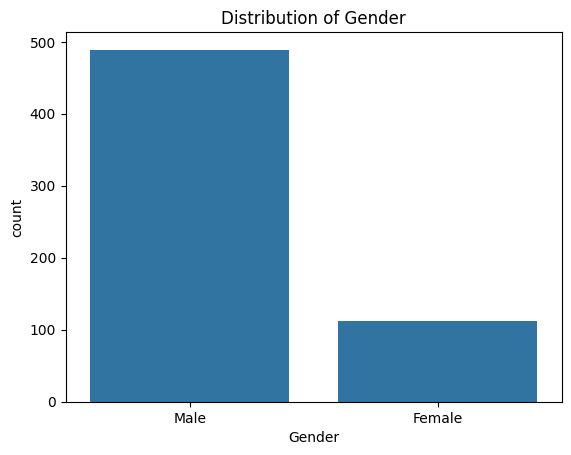

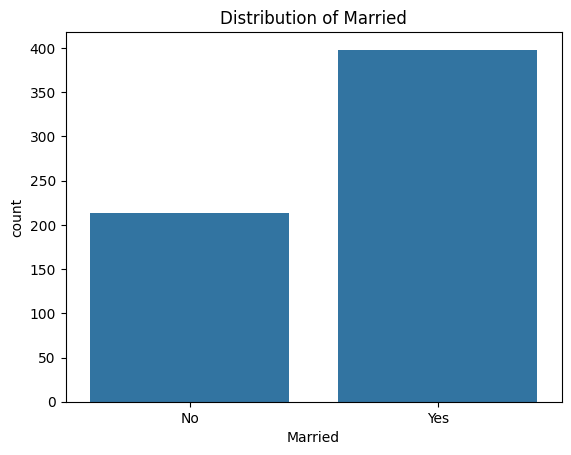

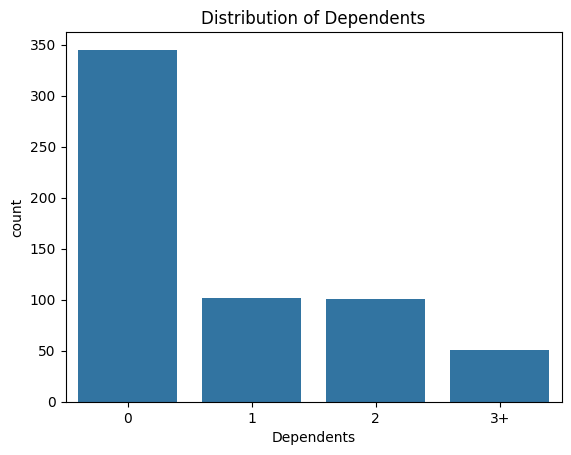

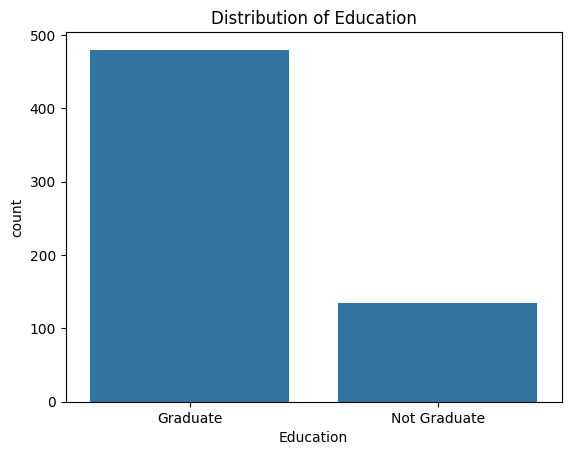

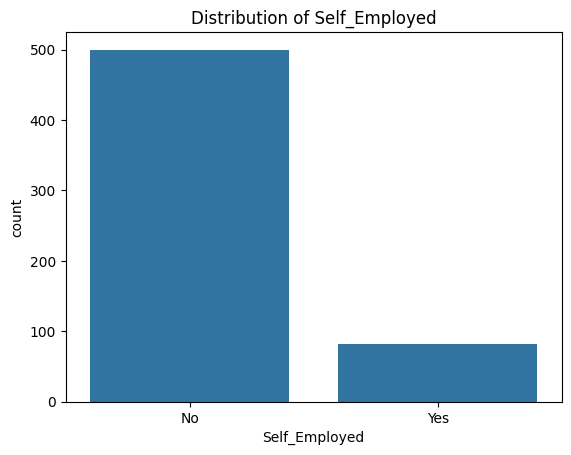

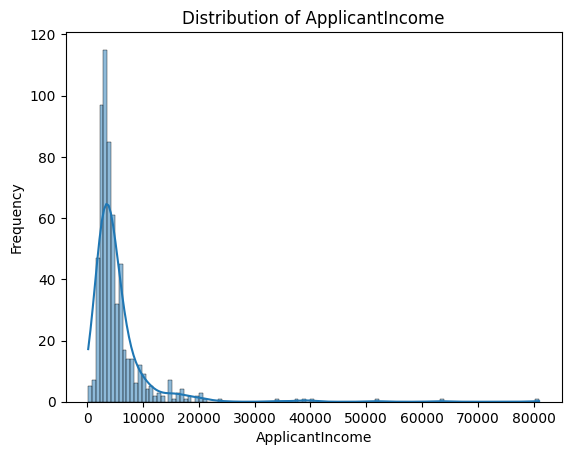

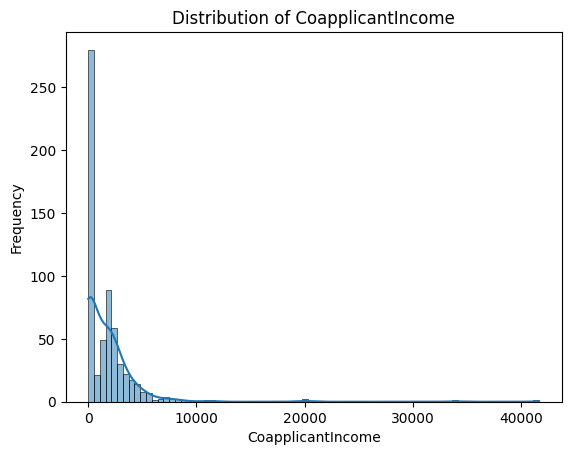

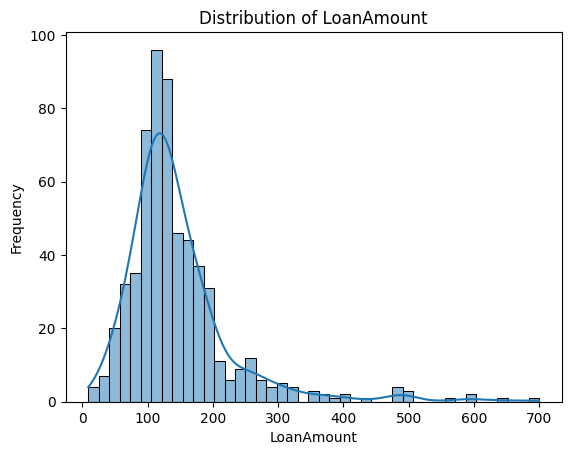

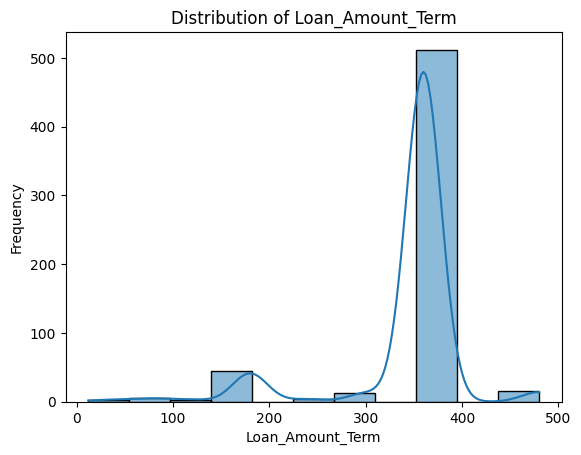

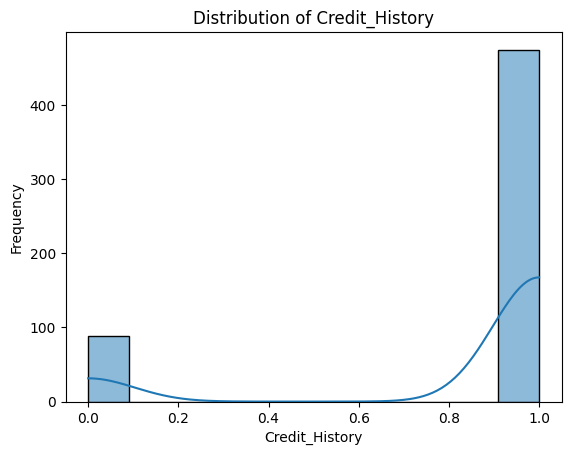

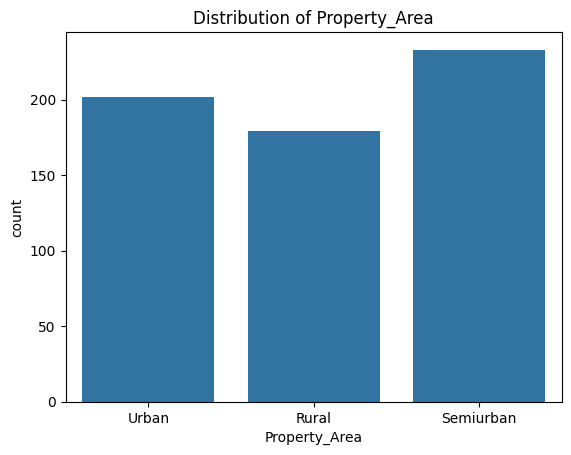

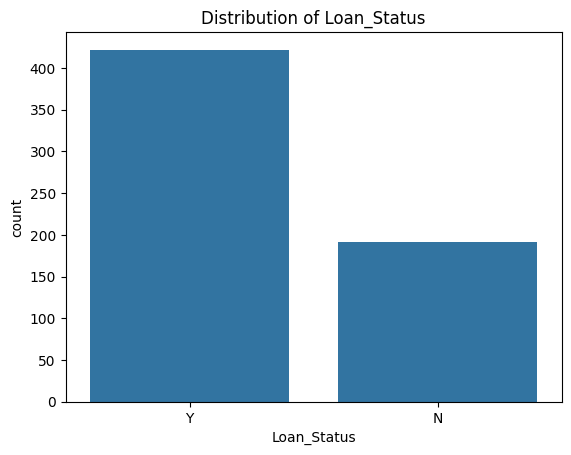

In [41]:
for column in df_load_raw.columns:
    if df_load_raw[column].dtype == 'object':
        # Using a countplot for categorical variables
        sns.countplot(x = column, data = df_load_raw)
        plt.title(f'Distribution of {column}')
        plt.show()
    else:
        # Using a histogram for numerical variables
        sns.histplot(df_load_raw[column], kde = True)
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {column}')
        plt.show()

### <u>Bivariate Analysis -> Looking at variable relationships

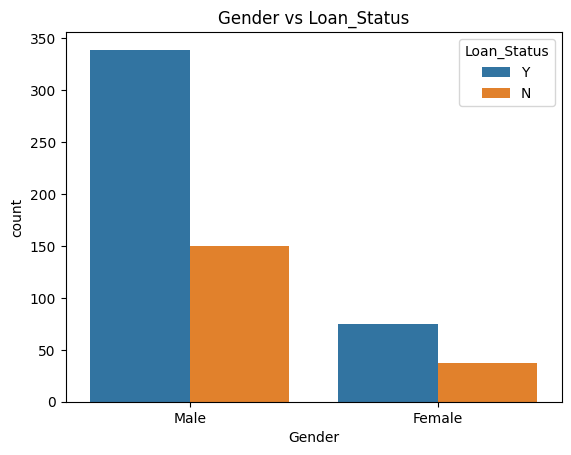

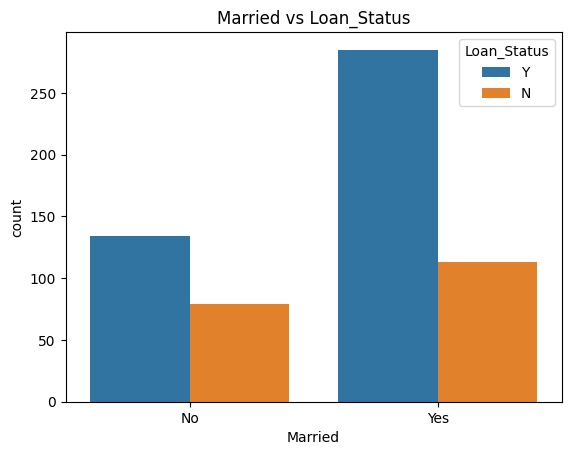

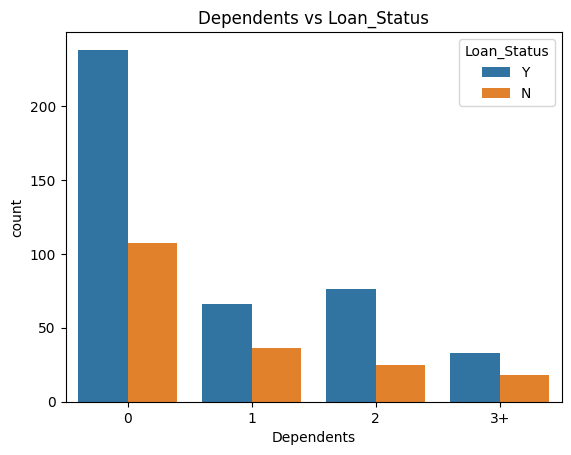

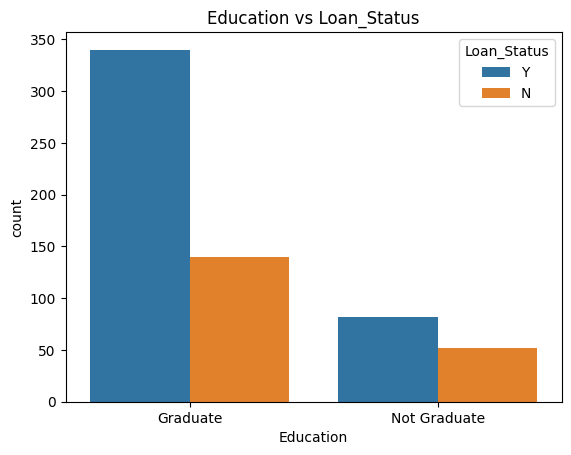

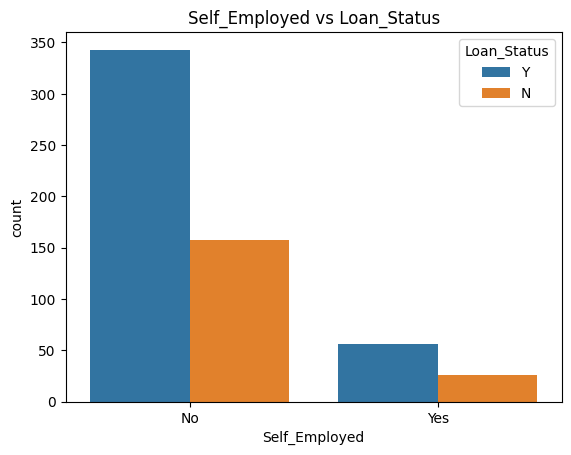

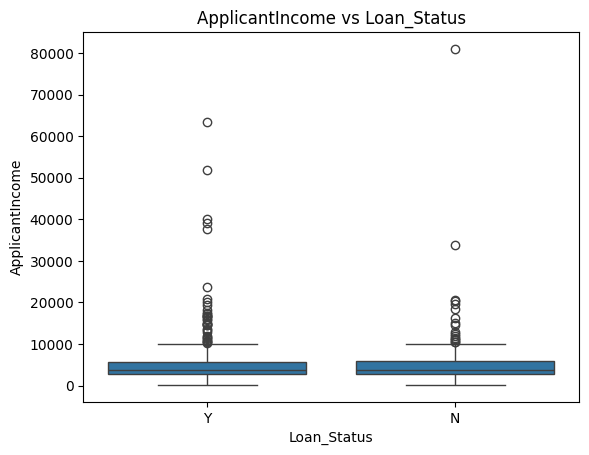

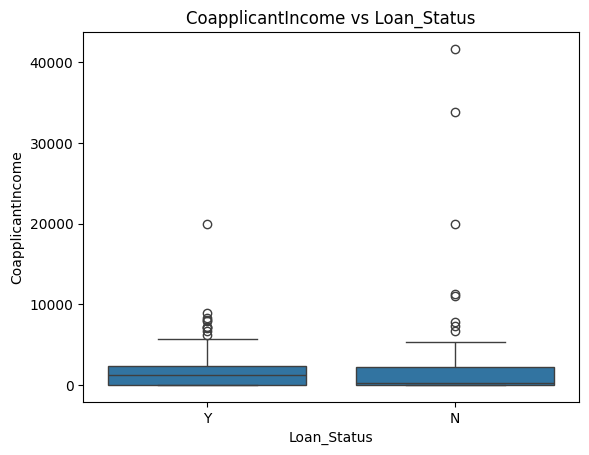

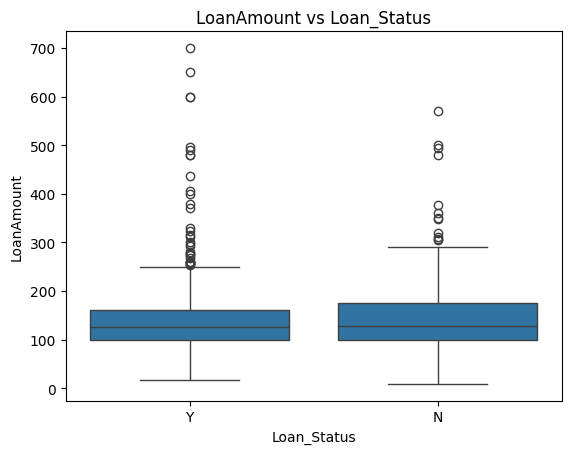

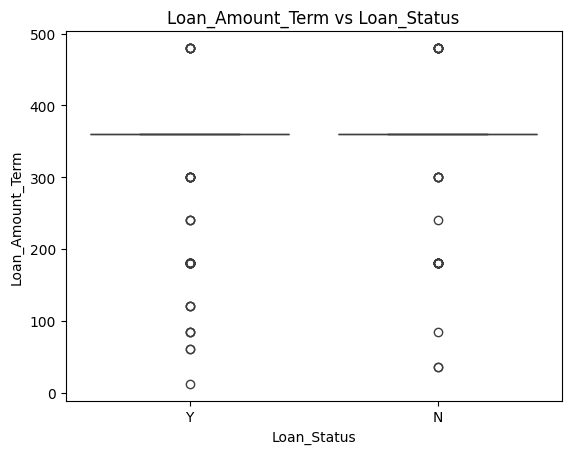

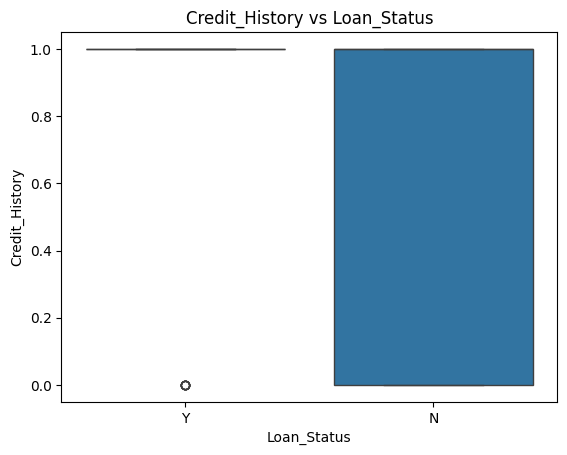

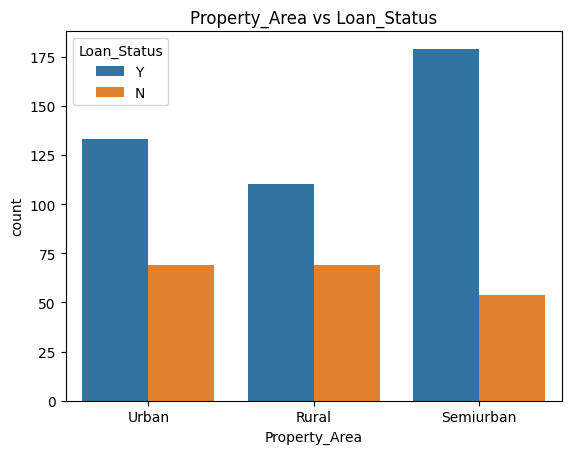

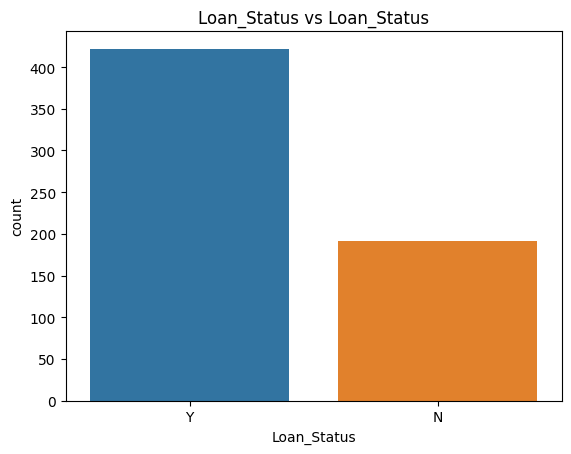

In [42]:
for column in df_load_raw.columns:
    if df_load_raw[column].dtype == 'object':
        # Using a countplot for categorical variables
        sns.countplot(x = column, hue ='Loan_Status', data = df_load_raw)
        plt.title(f'{column} vs Loan_Status')
        plt.show()
    else:
        # Using a boxplot for numerical variables
        sns.boxplot(x ='Loan_Status', y = column, data = df_load_raw)
        plt.title(f'{column} vs Loan_Status')
        plt.show()

--------------
-----------

# Step 5. Missing value and outlier treatment

### <u>Identifying missing values

In [43]:
# Na valeus are the missing ones from skim
skim(df_load_raw)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 614    │ │ string      │ 7     │                                                          │
│ │ Number of columns │ 12     │ │ float64     │ 4     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %   ┃ mean   ┃ sd     ┃ p0   ┃ p25    ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ ApplicantIncome        │   0 │      0 │   5400 │   6100 │  150 │   2900 │  3800 │  5800 │  81000 │    ▇    │  │
│ │ CoapplicantIncome      │   0 │      0 │   1600 │   2900 │    0 │      0 │  1200 │  2300 │  42000 │    ▇    │  │
│ │ LoanAmount             │  22 │   3.58 │    150 │     86 │    9 │    100 │   130 │   170 │    700 │   ▇▇▁   │  │
│ │ Loan_Amount_Term       │  14 │   2.28 │    340 │     65 │   12 │    360 │   360 │   360 │    480 │    ▁ ▇  │  │
│ │ Credit_History         │  50 │   8.14 │   0.84 │   0.36 │    0 │      1 │     1 │     1 │      1 │ ▁    ▇  │  │
│ └────────────────────────┴─────┴────────┴────────┴────────┴──────┴────────┴───────┴───────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                  ┃ NA     ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Gender                       │     13 │       2.12 │                        0.98 │                     601 │  │
│ │ Married                      │      3 │       0.49 │                           1 │                     611 │  │
│ │ Dependents                   │     15 │       2.44 │                        0.98 │                     599 │  │
│ │ Education                    │      0 │          0 │                         1.2 │                     748 │  │
│ │ Self_Employed                │     32 │       5.21 │                        0.95 │                     582 │  │
│ │ Property_Area                │      0 │          0 │                           1 │                     614 │  │
│ │ Loan_Status                  │      0 │          0 │                           1 │                     614 │  │
│ └──────────────────────────────┴────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

### <u>Strategy for missing values

-> For numerical values we will use the mean to fill empty values

-> For categorical Values we will use the most frequent value to fill emply values

In [44]:
df_load_raw['LoanAmount'].fillna(df_load_raw['LoanAmount'].mean(), inplace=True)
df_load_raw['Loan_Amount_Term'].fillna(df_load_raw['Loan_Amount_Term'].mode()[0], inplace=True) 
df_load_raw['Credit_History'].fillna(df_load_raw['Credit_History'].mode()[0], inplace=True)

df_load_raw['Gender'].fillna(df_load_raw['Gender'].mode()[0], inplace=True)
df_load_raw['Married'].fillna(df_load_raw['Married'].mode()[0], inplace=True)
df_load_raw['Dependents'].fillna(df_load_raw['Dependents'].mode()[0], inplace=True)
df_load_raw['Self_Employed'].fillna(df_load_raw['Self_Employed'].mode()[0], inplace=True)

missing_values = (
    df_load_raw.isnull().sum()/len(df_load_raw)*100
).round(0).astype(int)

missing_values

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int32

### <u>Identifying Outliers

In [45]:
for col in df_load_raw.columns:
    if df_load_raw[col].dtype == 'float64' or df_load_raw[col].dtype == 'int64':
        fig = px.box(
            df_load_raw, 
            x = col, 
            orientation='h',
            title=f'Boxplot of the {col} Target  - With Outliers'
        )
        fig.update_layout(xaxis_title='Target')
        fig.show()

### <u>Removing Outliers

In [46]:
#Removing data from the dataset which doesn't comply to the specified rule
min_mask = lambda col, val: df_load_raw[col] < val
income_mask = min_mask('ApplicantIncome',10000)
coapplicant_income_mask = min_mask('CoapplicantIncome',5701)
loan_ammount_mask = min_mask('LoanAmount',260)

df_raw_new = df_load_raw[income_mask & coapplicant_income_mask & loan_ammount_mask]

if 'Loan_Status' in df_raw_new.columns:
        df_raw_new['Loan_Status'] = df_raw_new['Loan_Status'].apply(lambda s: 1 if s == 'Y' else 0)
        
        
ohe = OneHotEncoder(
    use_cat_names=True, 
    cols=['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area']
    )

encoded_df = ohe.fit_transform(df_raw_new)
  
encoded_df

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\2923300020.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gender_Male,Gender_Female,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_3+,Dependents_2,Education_Graduate,Education_Not Graduate,...,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History_1.0,Credit_History_0.0,Property_Area_Urban,Property_Area_Rural,Property_Area_Semiurban,Loan_Status
0,1,0,1,0,1,0,0,0,1,0,...,5849,0.0,146.412162,360.0,1,0,1,0,0,1
1,1,0,0,1,0,1,0,0,1,0,...,4583,1508.0,128.000000,360.0,1,0,0,1,0,0
2,1,0,0,1,1,0,0,0,1,0,...,3000,0.0,66.000000,360.0,1,0,1,0,0,1
3,1,0,0,1,1,0,0,0,0,1,...,2583,2358.0,120.000000,360.0,1,0,1,0,0,1
4,1,0,1,0,1,0,0,0,1,0,...,6000,0.0,141.000000,360.0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,1,1,0,1,0,0,0,1,0,...,2900,0.0,71.000000,360.0,1,0,0,1,0,1
610,1,0,0,1,0,0,1,0,1,0,...,4106,0.0,40.000000,180.0,1,0,0,1,0,1
611,1,0,0,1,0,1,0,0,1,0,...,8072,240.0,253.000000,360.0,1,0,1,0,0,1
612,1,0,0,1,0,0,0,1,1,0,...,7583,0.0,187.000000,360.0,1,0,1,0,0,1


-----------
----------

# Non Feature Preparatoin

In [47]:
def prepare_data1(data):
    df_raw_new = pd.read_csv(data)
    
    if 'Loan_ID' in df_raw_new.columns:
        df_raw_new.drop(columns = 'Loan_ID', inplace=True)

    df_raw_new['Credit_History'] = df_raw_new['Credit_History'].astype(object)
    missing_values = (
        df_raw_new.isnull().sum()/len(df_raw_new)*100
    ).round(0).astype(int)

    df_raw_new['LoanAmount'].fillna(df_raw_new['LoanAmount'].mean(), inplace=True)
    df_raw_new['Loan_Amount_Term'].fillna(df_raw_new['Loan_Amount_Term'].mode()[0], inplace=True) 
    df_raw_new['Credit_History'].fillna(df_raw_new['Credit_History'].mode()[0], inplace=True)

    df_raw_new['Gender'].fillna(df_raw_new['Gender'].mode()[0], inplace=True)
    df_raw_new['Married'].fillna(df_raw_new['Married'].mode()[0], inplace=True)
    df_raw_new['Dependents'].fillna(df_raw_new['Dependents'].mode()[0], inplace=True)
    df_raw_new['Self_Employed'].fillna(df_raw_new['Self_Employed'].mode()[0], inplace=True)

    min_mask = lambda col, val: df_raw_new[col] < val
    income_mask = min_mask('ApplicantIncome',10000)
    coapplicant_income_mask = min_mask('CoapplicantIncome',5701)
    loan_ammount_mask = min_mask('LoanAmount',260)

    df_raw_new1 = df_raw_new[income_mask & coapplicant_income_mask & loan_ammount_mask]

    if 'Loan_Status' in df_raw_new1.columns:
        df_raw_new1['Loan_Status'] = df_raw_new1['Loan_Status'].apply(lambda s: 1 if s == 'Y' else 0)
        
    ohe = OneHotEncoder(
    use_cat_names=True, 
    cols=['Gender', 'Dependents', 'Married', 'Education', 'Self_Employed', 'Credit_History','Property_Area']
    )

    encoded_df = ohe.fit_transform(df_raw_new1)

    return encoded_df



In [48]:
(prepare_data1('../data/raw_data.csv'))

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\236248400.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Gender_Male,Gender_Female,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_3+,Dependents_2,Education_Graduate,Education_Not Graduate,...,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History_1.0,Credit_History_0.0,Property_Area_Urban,Property_Area_Rural,Property_Area_Semiurban,Loan_Status
0,1,0,1,0,1,0,0,0,1,0,...,5849,0.0,146.412162,360.0,1,0,1,0,0,1
1,1,0,0,1,0,1,0,0,1,0,...,4583,1508.0,128.000000,360.0,1,0,0,1,0,0
2,1,0,0,1,1,0,0,0,1,0,...,3000,0.0,66.000000,360.0,1,0,1,0,0,1
3,1,0,0,1,1,0,0,0,0,1,...,2583,2358.0,120.000000,360.0,1,0,1,0,0,1
4,1,0,1,0,1,0,0,0,1,0,...,6000,0.0,141.000000,360.0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,1,1,0,1,0,0,0,1,0,...,2900,0.0,71.000000,360.0,1,0,0,1,0,1
610,1,0,0,1,0,0,1,0,1,0,...,4106,0.0,40.000000,180.0,1,0,0,1,0,1
611,1,0,0,1,0,1,0,0,1,0,...,8072,240.0,253.000000,360.0,1,0,1,0,0,1
612,1,0,0,1,0,0,0,1,1,0,...,7583,0.0,187.000000,360.0,1,0,1,0,0,1


--------------------------
-----------------

# Step 8. Feature engineering

# Feature Encoded Preperation

In [49]:

def prepare_data2(data):
    df_raw_new = pd.read_csv(data)
    
    if 'Loan_ID' in df_raw_new.columns:
        df_raw_new.drop(columns = 'Loan_ID', inplace=True)

    df_raw_new['Credit_History'] = df_raw_new['Credit_History'].astype(object)
    missing_values = (
        df_raw_new.isnull().sum()/len(df_raw_new)*100
    ).round(0).astype(int)

    df_raw_new['LoanAmount'].fillna(df_raw_new['LoanAmount'].mean(), inplace=True)
    df_raw_new['Loan_Amount_Term'].fillna(df_raw_new['Loan_Amount_Term'].mode()[0], inplace=True) 
    df_raw_new['Credit_History'].fillna(df_raw_new['Credit_History'].mode()[0], inplace=True)

    df_raw_new['Gender'].fillna(df_raw_new['Gender'].mode()[0], inplace=True)
    df_raw_new['Married'].fillna(df_raw_new['Married'].mode()[0], inplace=True)
    df_raw_new['Dependents'].fillna(df_raw_new['Dependents'].mode()[0], inplace=True)
    df_raw_new['Self_Employed'].fillna(df_raw_new['Self_Employed'].mode()[0], inplace=True)

    min_mask = lambda col, val: df_raw_new[col] < val
    income_mask = min_mask('ApplicantIncome',10000)
    coapplicant_income_mask = min_mask('CoapplicantIncome',5701)
    loan_ammount_mask = min_mask('LoanAmount',260)

    df_raw_new1 = df_raw_new[income_mask & coapplicant_income_mask & loan_ammount_mask]

    if 'Loan_Status' in df_raw_new1.columns:
        df_raw_new1['Loan_Status'] = df_raw_new1['Loan_Status'].apply(lambda s: 1 if s == 'Y' else 0)
    
    df_raw_new1['Total_Income'] = df_raw_new1['ApplicantIncome'] + df_raw_new1['CoapplicantIncome']
    df_raw_new1['Loan_Term_Category'] = pd.cut(df_raw_new1['Loan_Amount_Term'], bins=[0, 180, 360, 600], labels=['Short-term', 'Medium-term', 'Long-term'])
    df_raw_new1['Income_Stability'] = df_raw_new1[['ApplicantIncome', 'CoapplicantIncome']].std(axis=1)
    df_raw_new1['Loan_to_Income_ratio'] = df_raw_new1['LoanAmount'] / ((df_raw_new1['ApplicantIncome'] + df_raw_new1['CoapplicantIncome']))
    
    df_raw_new1['Loan_Term_Category'] = df_raw_new1['Loan_Term_Category'].astype(object)
        
    ohe = OneHotEncoder(
        use_cat_names=True, 
        cols=['Gender','Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History','Property_Area', 'Loan_Term_Category']
        )

    encoded_df = ohe.fit_transform(df_raw_new1)

    return encoded_df


In [50]:
prepare_data2('../data/raw_data.csv')

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Gender_Male,Gender_Female,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_3+,Dependents_2,Education_Graduate,Education_Not Graduate,...,Property_Area_Urban,Property_Area_Rural,Property_Area_Semiurban,Loan_Status,Total_Income,Loan_Term_Category_Medium-term,Loan_Term_Category_Short-term,Loan_Term_Category_Long-term,Income_Stability,Loan_to_Income_ratio
0,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,5849.0,1,0,0,4135.867563,0.025032
1,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,6091.0,1,0,0,2174.353352,0.021015
2,1,0,0,1,1,0,0,0,1,0,...,1,0,0,1,3000.0,1,0,0,2121.320344,0.022000
3,1,0,0,1,1,0,0,0,0,1,...,1,0,0,1,4941.0,1,0,0,159.099026,0.024287
4,1,0,1,0,1,0,0,0,1,0,...,1,0,0,1,6000.0,1,0,0,4242.640687,0.023500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,1,1,0,1,0,0,0,1,0,...,0,1,0,1,2900.0,1,0,0,2050.609665,0.024483
610,1,0,0,1,0,0,1,0,1,0,...,0,1,0,1,4106.0,0,1,0,2903.380444,0.009742
611,1,0,0,1,0,1,0,0,1,0,...,1,0,0,1,8312.0,1,0,0,5538.060310,0.030438
612,1,0,0,1,0,0,0,1,1,0,...,1,0,0,1,7583.0,1,0,0,5361.990722,0.024660


--------------------------
-----------------

# Step 6. Evaluation Metrics for classification problem

# Test of Model 1

In [51]:


df = prepare_data1('../data/raw_data.csv')
X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model():
    model = Sequential([
        Dense(21, activation='relu', input_shape=(21,)),
        Dense(8, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=32, verbose=0)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = cross_val_score(model, X_train_scaled, y_train, cv=kfold)

print("Cross-validation Accuracy: %.2f%% (+/- %.2f%%)" % (results.mean() * 100, results.std() * 100))


C:\Users\encry\AppData\Local\Temp\ipykernel_19700\236248400.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\encry\anaconda3\envs\MLG_382_Env\Lib\site-packages\scikeras\wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

c:\Users\encry\anaconda3\envs\MLG_382_Env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

c:\Users\encry\anaconda3\envs\MLG_382_Env\Lib\site-packages\scikeras\wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``

Cross-validation Accuracy: 80.63% (+/- 3.95%)


--------------------------
-----------------

# Step 6. Evaluation Metrics for classification problem

# Test of Model 2

In [52]:
df = prepare_data2('../data/raw_data.csv')
X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model():
    model = Sequential([
        Dense(27, activation='relu', input_shape=(27,)),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=15, batch_size=32, verbose=0)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = cross_val_score(model, X_train_scaled, y_train, cv=kfold)

print("Cross-validation Accuracy: %.2f%% (+/- %.2f%%)" % (results.mean() * 100, results.std() * 100))



C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

Cross-validation Accuracy: 80.62% (+/- 2.80%)


--------------------------
-----------------

# Step 7. Model building: part 1 

In [53]:

df = prepare_data1('../data/raw_data.csv')
X = df.drop(['Loan_Status'], axis=1)
Y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model():
    model = Sequential([
        Dense(21, activation='relu', input_shape=(21,)),
        Dense(8, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()  
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_data=(X_test_scaled, y_test))

joblib.dump(model, '../model1.pkl')

model = joblib.load('../artifacts/model1.pkl')

datav = prepare_data1('../data/validation.csv')

datav = datav.iloc[:, [0, 1, 3, 2, 4, 5, 7, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 19]]

X_val_scaled = scaler.transform(datav)

predictions = model.predict(X_val_scaled)

predictions_arr = []

for status in predictions:
    if status > 0.5:
        predictions_arr.append('Yes')
    else:
        predictions_arr.append('No')

print(predictions_arr)

Epoch 1/15


C:\Users\encry\AppData\Local\Temp\ipykernel_19700\236248400.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\encry\anaconda3\envs\MLG_382_Env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6750 - loss: 0.6494 - val_accuracy: 0.7358 - val_loss: 0.6074
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6700 - loss: 0.6276 - val_accuracy: 0.7358 - val_loss: 0.5806
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6674 - loss: 0.6089 - val_accuracy: 0.7642 - val_loss: 0.5594
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6554 - loss: 0.5871 - val_accuracy: 0.7642 - val_loss: 0.5474
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7041 - loss: 0.5566 - val_accuracy: 0.7642 - val_loss: 0.5346
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7218 - loss: 0.5157 - val_accuracy: 0.7642 - val_loss: 0.5262
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7044 - loss: 0.5204 - val_accuracy: 0.8208 - val_loss: 0.5207
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.4785 - val_accuracy: 0.8113 - val_loss: 0.5144
Ep

--------------------------
-----------------

# Step 9. Model building: part 2 

In [54]:
df = prepare_data2('../data/raw_data.csv')

X = df.drop(['Loan_Status'], axis=1)
y = df['Loan_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model():
    model = Sequential([
        Dense(27, activation='relu', input_shape=(27,)),
        Dense(16, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()  
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_data=(X_test_scaled, y_test))

joblib.dump(model, '../artifacts/model2.pkl')

model = joblib.load('../artifacts/model2.pkl')

datav = prepare_data2('../data/validation.csv')

datav = datav.iloc[:, [0, 1, 3, 2, 4, 5, 7, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 19, 21, 22, 23, 24, 25, 26]]

X_val_scaled = scaler.transform(datav)

predictions = model.predict(X_val_scaled)

predictions_arr = []

for status in predictions:
    if status > 0.5:
        predictions_arr.append('Yes')
    else:
        predictions_arr.append('No')

print(predictions_arr)

Epoch 1/15


C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4603 - loss: 0.7094 - val_accuracy: 0.5849 - val_loss: 0.6618
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7116 - loss: 0.6304 - val_accuracy: 0.7358 - val_loss: 0.5974
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7822 - loss: 0.5775 - val_accuracy: 0.8019 - val_loss: 0.5557
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8038 - loss: 0.5380 - val_accuracy: 0.8113 - val_loss: 0.5286
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8124 - loss: 0.5187 - val_accuracy: 0.8208 - val_loss: 0.5042
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7933 - loss: 0.5049 - val_accuracy: 0.8396 - val_loss: 0.4856
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8209 - loss: 0.4471 - val_accuracy: 0.8491 - val_loss: 0.4686
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8196 - loss: 0.4447 - val_accuracy: 0.8491 - val_loss: 0.4603
Epo

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\encry\AppData\Local\Temp\ipykernel_19700\1110701930.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

--------------------------
-----------------

# Milestone 3: DASH Web Application Development

# Step 10 Model deployment 

In [56]:
# Initialize Dash app
app = dash.Dash(__name__)
server = app.server

# Define layout
app.layout = html.Div([
    html.H1("Loan Application"),
    html.Div([
        html.Label("Loan_ID"),
        dcc.Input(id='input1', type='text')
    ]),
    html.Div([
        html.Label("Gender"),
        dcc.Input(id='input2', type='text')
    ]),
    html.Div([
        html.Label("Married"),
        dcc.Input(id='input3', type='text')
    ]),
    html.Div([
        html.Label("Dependents"),
        dcc.Input(id='input4', type='text')
    ]),
    html.Div([
        html.Label("Education"),
        dcc.Input(id='input5', type='text')
    ]),
    html.Div([
        html.Label("Self_Employed"),
        dcc.Input(id='input6', type='text')
    ]),
    html.Div([
        html.Label("ApplicantIncome"),
        dcc.Input(id='input7', type='text')
    ]),
    html.Div([
        html.Label("CoapplicantIncome"),
        dcc.Input(id='input8', type='text')
    ]),
    html.Div([
        html.Label("LoanAmount"),
        dcc.Input(id='input9', type='text')
    ]),
    html.Div([
        html.Label("Loan_Amount_Term"),
        dcc.Input(id='input10', type='text')
    ]),
    html.Div([
        html.Label("Credit_History"),
        dcc.Input(id='input11', type='text')
    ]),
    html.Div([
        html.Label("Property_Area"),
        dcc.Input(id='input12', type='text')
    ]),
    
    html.Button('Submit', id='submit-val', n_clicks=0),
    html.Div(id='output-div')
])

# Callback to handle button click and write to CSV
@app.callback(
    Output('output-div', 'children'),
    [Input('submit-val', 'n_clicks')],
    [Input('input{}'.format(i), 'value') for i in range(1, 13)]
)
def update_output(n_clicks, *inputs):
    if n_clicks > 0:
        # Create a DataFrame with the input data
        data = {'Input {}'.format(i): [val] for i, val in enumerate(inputs, start=1)}
        df = pd.DataFrame(data)
        
        # Append data to CSV file
        df.to_csv('../data/loan_applications.csv', mode='a', header=False, index=False)
        
        return make_prediction()
    
def make_prediction():
    prediction_data = prepare_data2('../data/loan_applications.csv')
    model = joblib.load('../artifacts/model1.pkl')
    
    scaler = StandardScaler()
    scaled_input = scaler.transform(prediction_data)
    
    prediction = model.predict(scaled_input)
    
    return prediction

if __name__ == '__main__':
    app.run_server(debug=True, port = 8020)

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[24], line 76, in update_output(
    n_clicks=3,
    *inputs=('2343', 'adf', 'asdf', 'asdf', 'sdf', 'asdf', 'asf', 'asf', 'asfd', 'asf', 'safd', 'asdf')
)
     73 # Append data to CSV file
     74 df.to_csv('../data/loan_applications.csv', mode='a', header=False, index=False)
---> 76 return make_prediction()

Cell In[56], line 79, in make_prediction()
     78 def make_prediction():
---> 79     prediction_data = prepare_data2('../data/loan_applications.csv')
     80     model = joblib.load('../artifacts/model1.pkl')
     82     scaler = StandardScaler()

Cell In[49], line 12, in prepare_data2(data='../data/loan_applications.csv')
      7 df_raw_new['Credit_History'] = df_raw_new['Credit_History'].astype(object)
      8 missing_values = (
      9     df_raw_new.isnull().sum()/len(df_raw_new)*100
     10 ).round(0).astype(int)
---> 